In [1]:
from mpytools import Catalog
import utils
import glob
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp

target_4m_lrg = Catalog.read('/pscratch/sd/a/arocher/4MOST/target_lrg_4most_v2.fits')
target_4m_bg = Catalog.read('/pscratch/sd/a/arocher/4MOST/target_bg_mag_r19_4most_v2.fits')
mask_pixmap = Catalog.read('/pscratch/sd/e/edmondc/antoine/Legacy_Imaging_DR10_footprint_128.fits')
features_pixmap = Catalog.read('/pscratch/sd/e/edmondc/antoine/pixweight-dr10-128-new.fits')



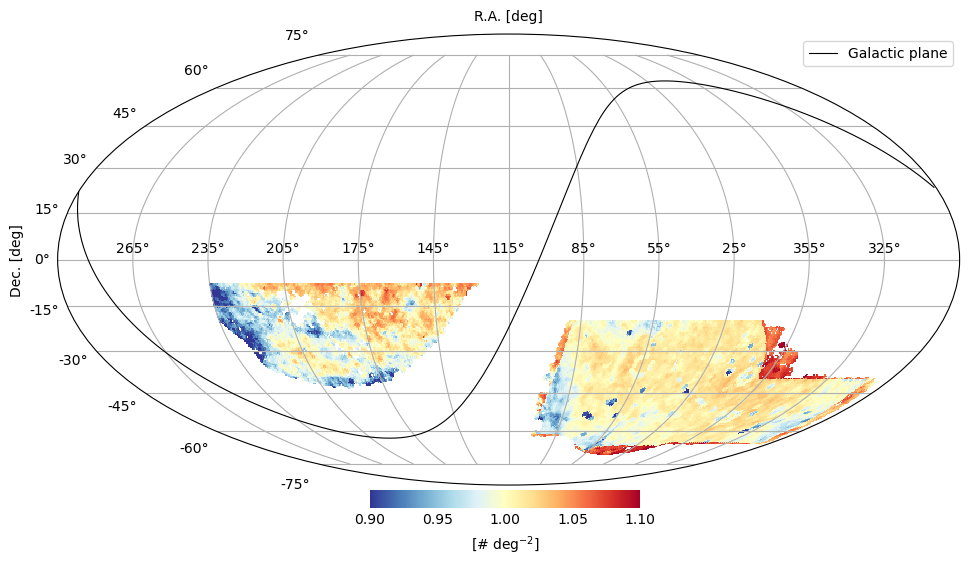

In [4]:
nside=128 
tracer='LRG'
cat_tar = target_4m_lrg if tracer=='LRG' else target_4m_bg
targets = utils.create_hp_map(cat_tar['RA'], cat_tar['DEC'], nside=nside, nest=True)

w = utils.get_wmap(targets, features_pixmap, mask_pixmap, tracer=tracer, regions=['DECALS', 'DES'])
utils.plot_moll(w, nest=True, min=0.9,max=1.1)

nflod 0 is running


nflod 0 done
nflod 1 is running
nflod 1 done
nflod 2 is running
nflod 2 done
nflod 3 is running
nflod 3 done
nflod 4 is running
nflod 4 done
nflod 5 is running
nflod 5 done
nflod 0 is running
nflod 0 done
nflod 1 is running
nflod 1 done
nflod 2 is running
nflod 2 done
nflod 3 is running
nflod 3 done
nflod 4 is running
nflod 4 done
nflod 5 is running
nflod 5 done


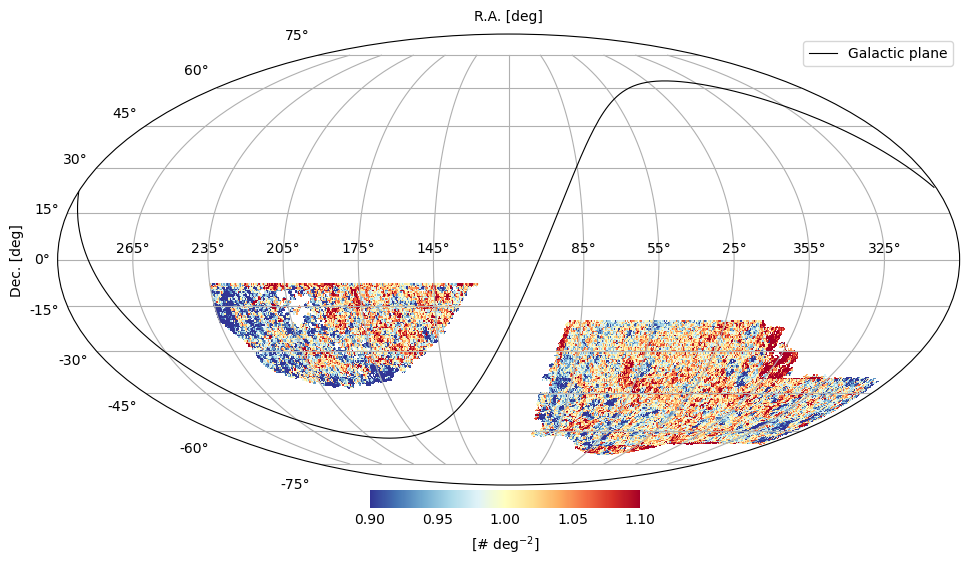

In [5]:
w_rf = utils.get_wmap(targets, features_pixmap, mask_pixmap, tracer=tracer, regions=['DECALS', 'DES'], regression_type='RF')
utils.plot_moll(w_rf, nest=True, min=0.9,max=1.1)

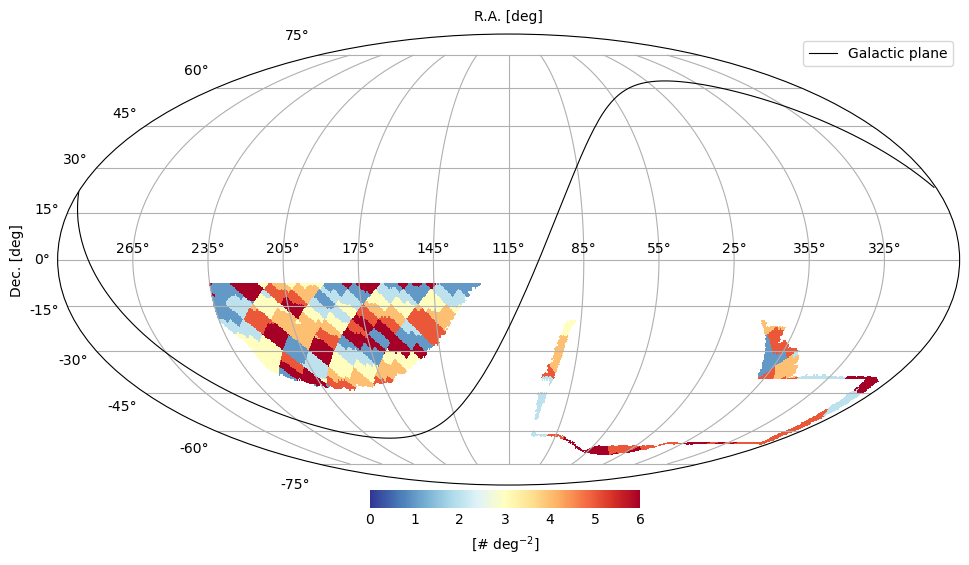

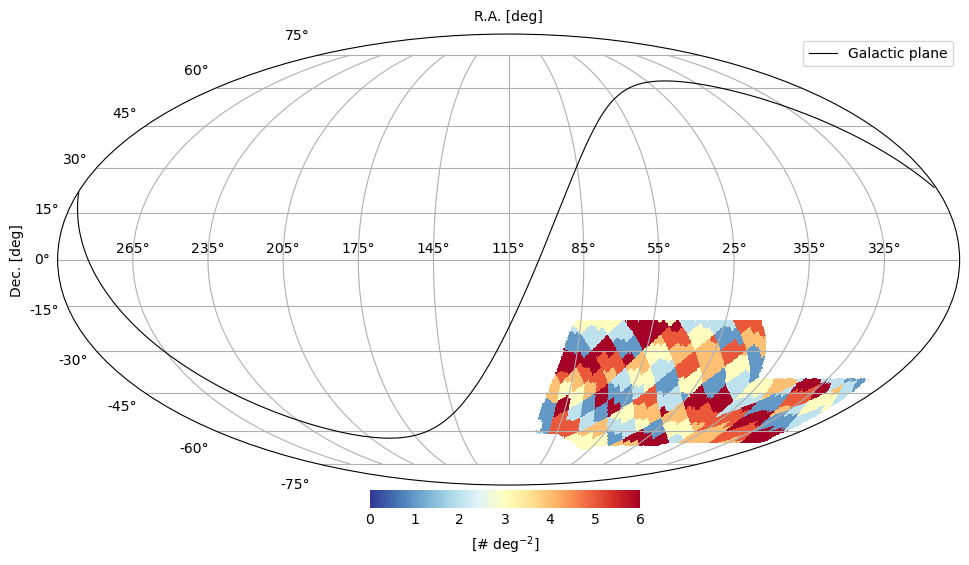

In [3]:
mask_DECALS = ~mask_pixmap['ISDES'] & mask_pixmap[f'IS4MOST_{tracer}']
mask_DES = mask_pixmap['ISDES'] & mask_pixmap[f'IS4MOST_{tracer}']
utils.plot_kfold(mask_DECALS)
utils.plot_kfold(mask_DES)

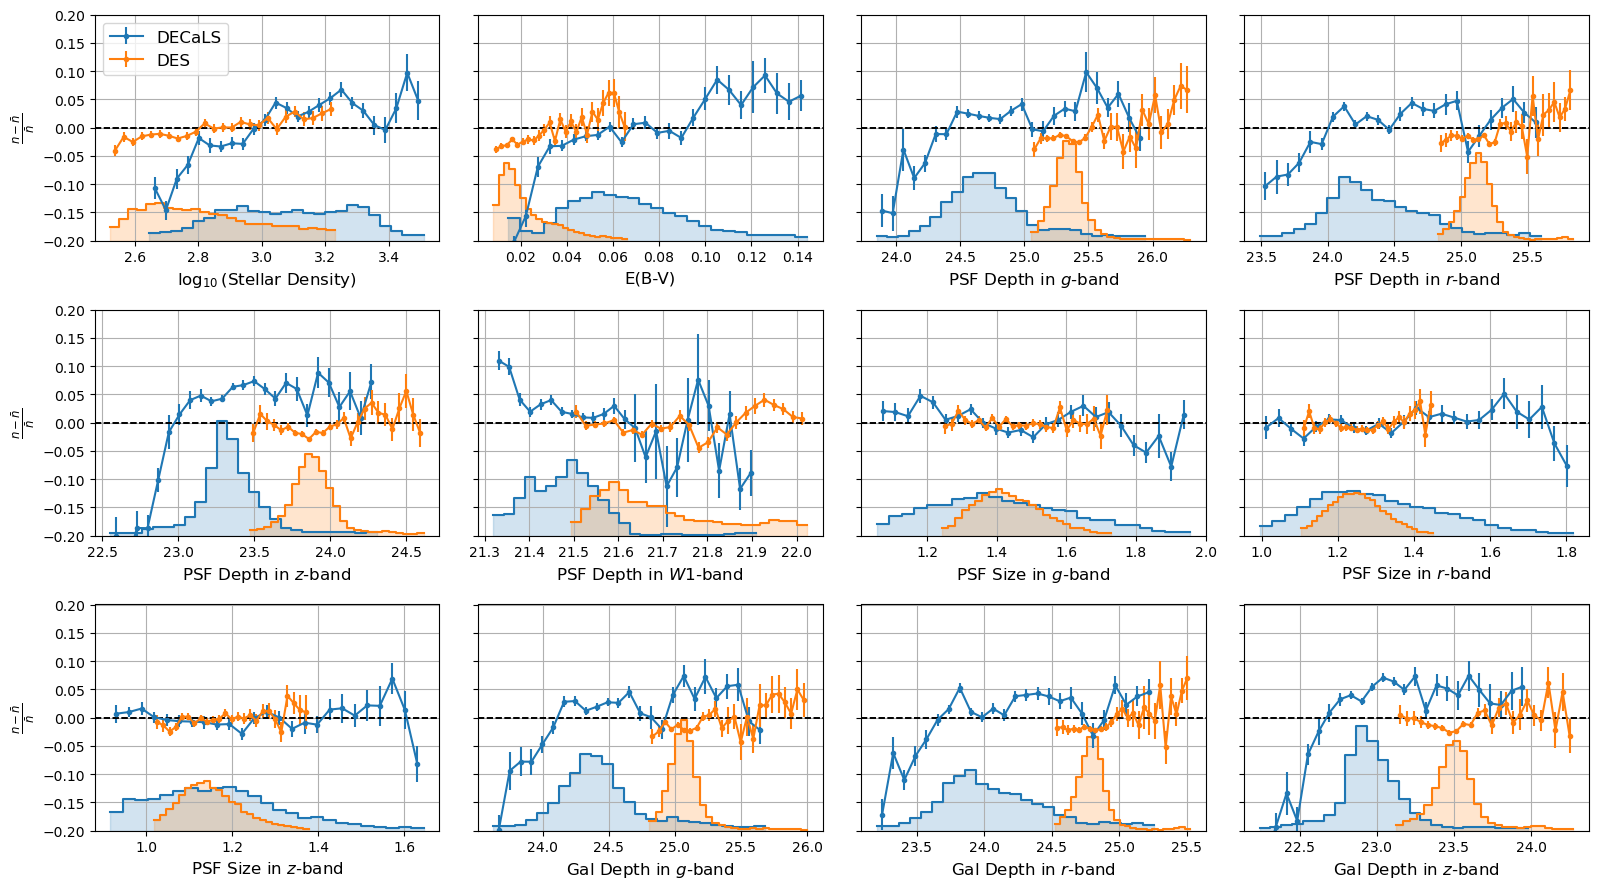

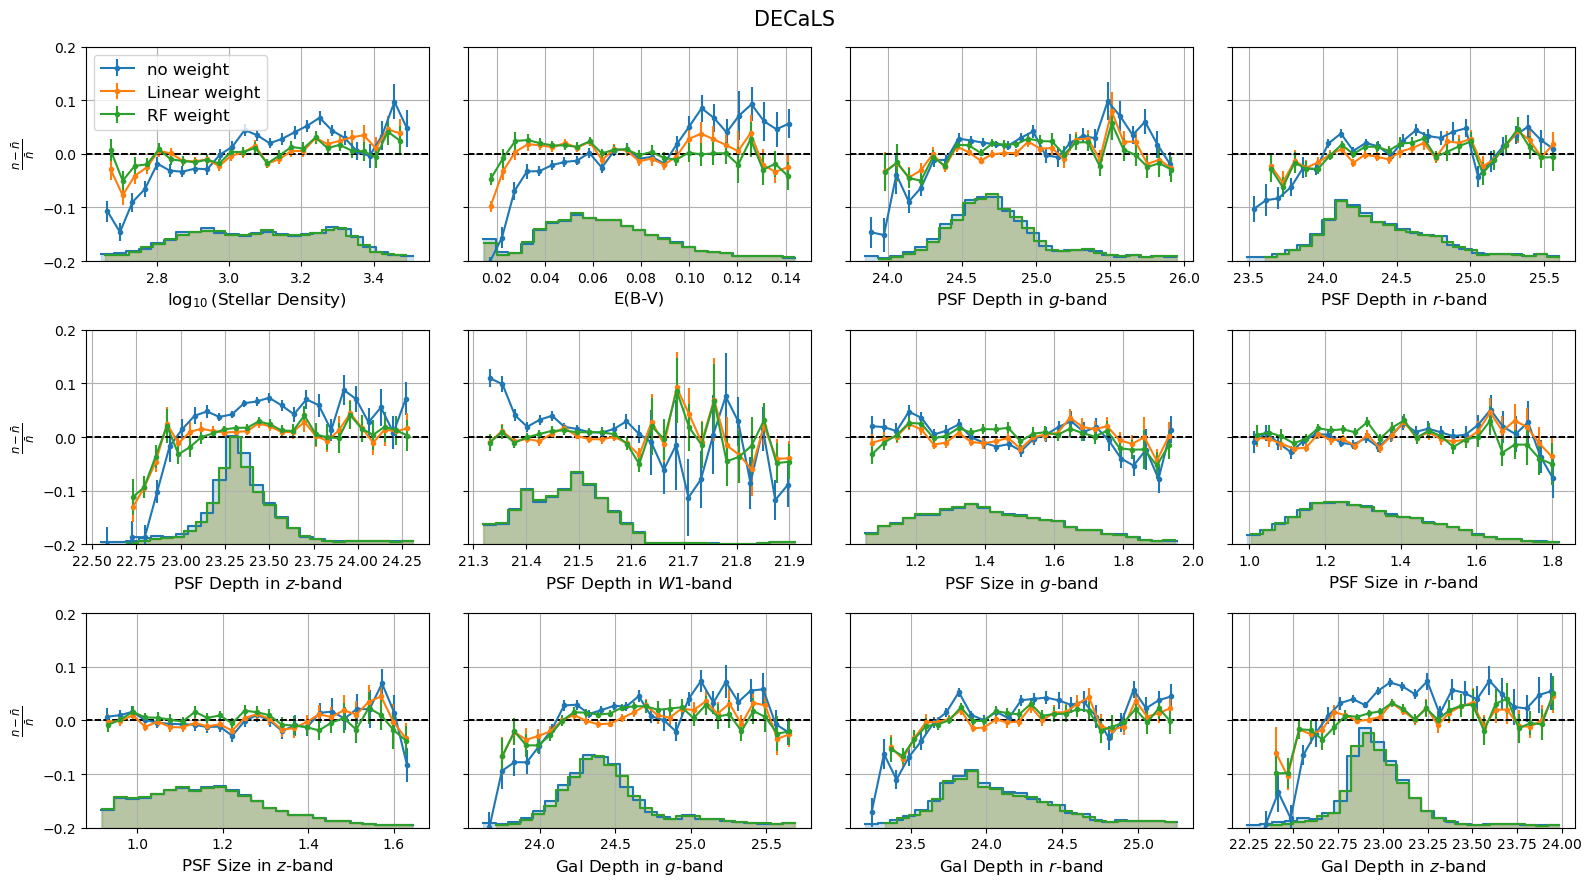

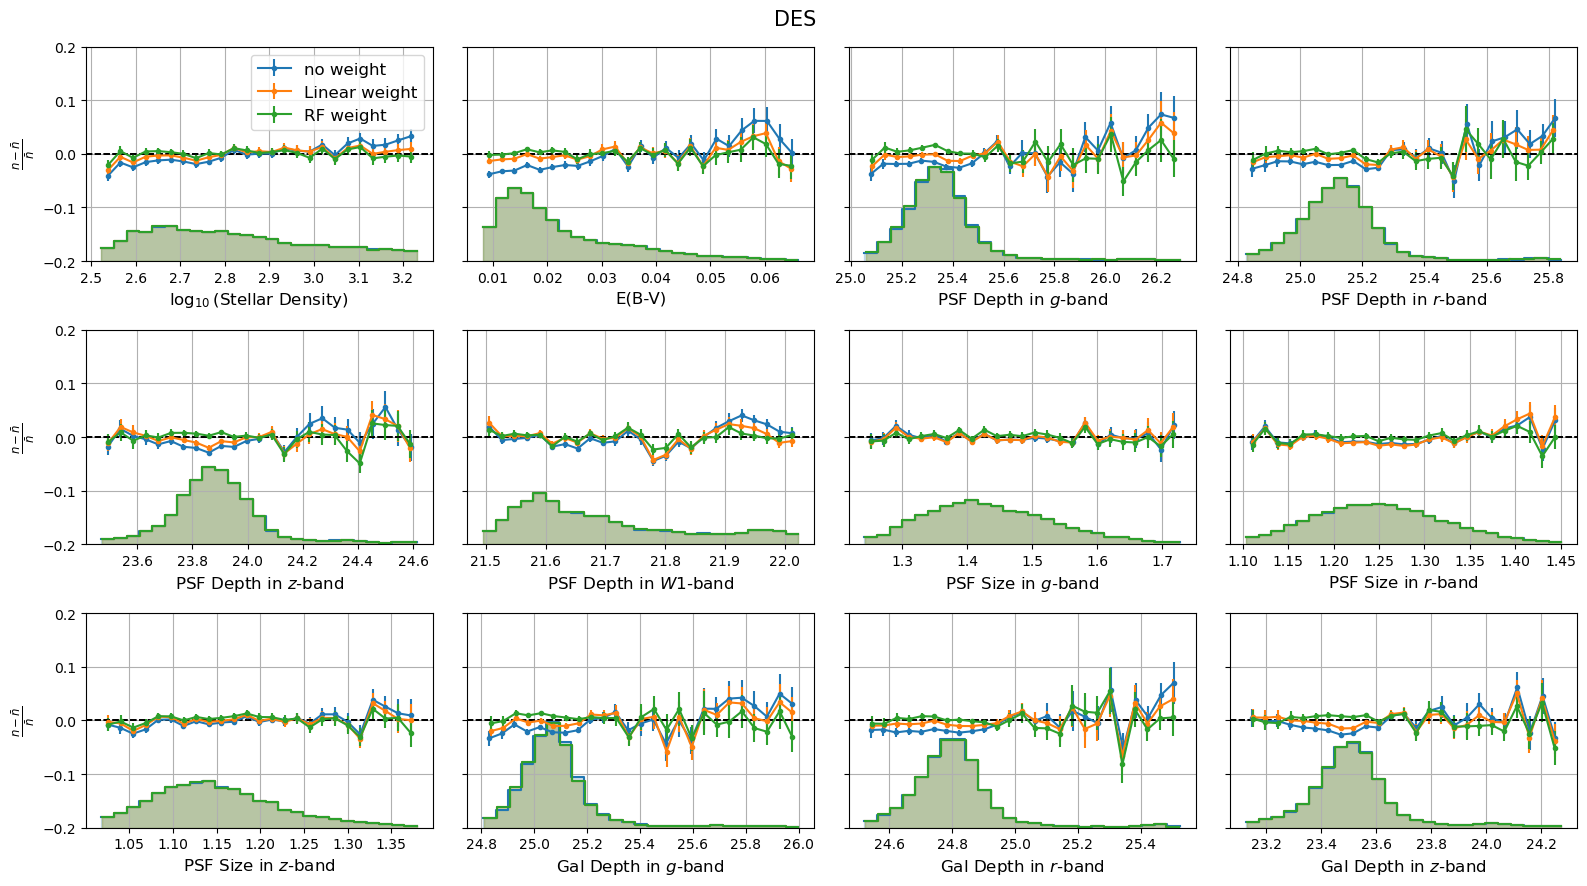

In [6]:
mask_DECALS = ~mask_pixmap['ISDES'] & mask_pixmap[f'IS4MOST_{tracer}']
mask_DES = mask_pixmap['ISDES'] & mask_pixmap[f'IS4MOST_{tracer}']

    
    
targets_map = [utils.apply_mask_to_hpmap(targets, mask_DECALS), utils.apply_mask_to_hpmap(targets, mask_DES)]
wtargets_map = [utils.apply_mask_to_hpmap(targets*w, mask_DECALS), utils.apply_mask_to_hpmap(targets*w, mask_DES)]
wrftargets_map = [utils.apply_mask_to_hpmap(targets*w_rf, mask_DECALS), utils.apply_mask_to_hpmap(targets*w_rf, mask_DES)]

labels_map = ['DECaLS', 'DES']
utils.plot_systmematics(targets_map, features_pixmap, labels_map=labels_map)

title = 'DECaLS'
labels_map = ['no weight', 'Linear weight', 'RF weight']
utils.plot_systmematics([targets_map[0], wtargets_map[0],wrftargets_map[0]], features_pixmap, labels_map=labels_map, fig_title=title)
title = 'DES'
utils.plot_systmematics([targets_map[1], wtargets_map[1], wrftargets_map[1]], features_pixmap, labels_map=labels_map, fig_title=title)



In [7]:
weights = utils.get_weight_from_wmap(cat_tar['RA'], cat_tar['DEC'], w)
weights.mean()

NameError: name 'cat_tar' is not defined